# User-Based Movie Recommendation System: Using Surprise Library
* **User-based recommendation:** Finding other similar users and seeing which movies are popular among them
* Surprise is a library used for building recommender systems

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Netflix Prize dataset: Setup and Some EDA

In [3]:
# Netflix Prize dataset ratings file
new_ratings = pd.read_csv('combined_data_1.txt', header=None, names=['userId', 'rating'], usecols=[0,1])
new_ratings.head()

,userId,rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [4]:
movie_ids = new_ratings[new_ratings['userId'].str.contains(':')][['userId']]
movie_ids = movie_ids['userId'].str.replace(":", "").astype(int)
movie_ids

0              1
548            2
694            3
2707           4
2850           5
            ... 
24046714    4495
24047329    4496
24056849    4497
24057564    4498
24057834    4499
Name: userId, Length: 4499, dtype: int64

In [5]:
def to_append(before_index, current_index, movie_id):
    return np.ones(current_index - before_index) * movie_id

In [6]:
# faster with preallocation but simpler approach
start_movie_ids = []
for i in range(1, len(movie_ids)):
    array = to_append(movie_ids.index[i-1], movie_ids.index[i], movie_ids.values[i-1])
    start_movie_ids = np.concatenate((start_movie_ids, array), axis=None)

In [7]:
# sanity check
len(start_movie_ids)

24057834

In [8]:
# add movie id 4499
start_movie_ids = np.concatenate((start_movie_ids, np.ones(429) * 4499), axis=None)
len(start_movie_ids)

24058263

In [9]:
new_ratings['movieId'] = start_movie_ids
new_ratings = new_ratings[['userId', 'movieId', 'rating']]
new_ratings.head()

,userId,movieId,rating
0,1:,1.0,NaN
1,1488844,1.0,3.0
2,822109,1.0,5.0
3,885013,1.0,4.0
4,30878,1.0,4.0


In [10]:
for col in new_ratings.columns:
    print(col, "NA values:", sum(new_ratings[col].isna()))

userId NA values: 0
movieId NA values: 0
rating NA values: 4499


* There are 4499 movie ids within the userId column. Movie ids do not have ratings and so the rating should be NA. Otherwise, there are no null values. The final dataframe will be completed after dropping where 'rating' is NA, aka the rows where the userId column contains a movieId.

In [11]:
# Final dataframe
ratings = new_ratings.dropna()
ratings['movieId'] = ratings['movieId'].apply(round) # movieIds showed as floats, rounding for cleanliness
ratings.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,userId,movieId,rating
1,1488844,1,3.0
2,822109,1,5.0
3,885013,1,4.0
4,30878,1,4.0
5,823519,1,3.0


In [12]:
# Counts of ratings
rating_sizes = ratings.groupby('rating').size()
rating_sizes

rating
1.0    1118186
2.0    2439073
3.0    6904181
4.0    8085741
5.0    5506583
dtype: int64

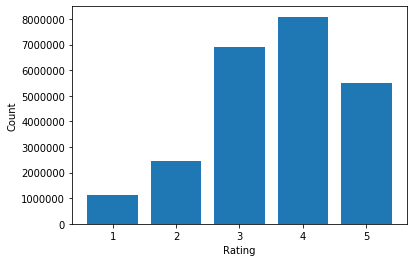

In [13]:
plt.bar(rating_sizes.index, height=rating_sizes.values)
plt.xlabel('Rating')
plt.ylabel('Count');

In [14]:
print("Num movies:", len(np.unique(ratings['movieId'])))
print("Num users:", len(np.unique(ratings['userId'])))
print("Num ratings:", ratings.shape[0])

Num movies: 4499
Num users: 470758
Num ratings: 24053764


In [15]:
ratings.dtypes

userId      object
movieId      int64
rating     float64
dtype: object

In [16]:
# Now that the movieIds ("1:") are gone, can make userId numbers into ints
ratings['userId'] = ratings['userId'].astype(int)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
# Netfix Prize dataset movies file
movies = pd.read_csv('movie_titles.csv', encoding='latin1')[['movieId', 'year', 'title']]
movies.head()

,movieId,year,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [18]:
# Combining ratings with their movie titles
rate_with_title = ratings.merge(movies, left_on='movieId', right_on='movieId')
rate_with_title = rate_with_title[['userId', 'movieId', 'title', 'year', 'rating']]
rate_with_title.head()

,userId,movieId,title,year,rating
0,1488844,1,Dinosaur Planet,2003.0,3.0
1,822109,1,Dinosaur Planet,2003.0,5.0
2,885013,1,Dinosaur Planet,2003.0,4.0
3,30878,1,Dinosaur Planet,2003.0,4.0
4,823519,1,Dinosaur Planet,2003.0,3.0


## Surprise

In [19]:
from surprise import SVD, SVDpp, KNNBaseline, KNNBasic, KNNWithMeans
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

reader = Reader()

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']][:100000], reader) # subset for now

In [ ]:
reference = []
for predictor in [SVD(), SVDpp(), KNNBaseline(), KNNBasic(), KNNWithMeans()]:
    results = cross_validate(predictor, data, measures=['RMSE'], cv=3)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(predictor).split(' ')[0].split('.')[-1]], index=['Predictor']))
    reference.append(tmp)
    
pd.DataFrame(reference).set_index('Predictor').sort_values('test_rmse')

Estimating biases using als...


* SVDpp performed the best among its peers according to its test rmse shown above, but it also took much time to run. SVD is a close runner-up indicated by its similar test rmse and takes significantly less time, therefore SVD will be used.

In [20]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3)

{'test_rmse': array([1.05343954, 1.05001665, 1.04649881]),
 'test_mae': array([0.83942605, 0.83829436, 0.83073187]),
 'fit_time': (4.038244962692261, 3.9881651401519775, 4.3971312046051025),
 'test_time': (0.2902710437774658, 0.25452613830566406, 0.20362091064453125)}

In [42]:
movie_size = ratings.groupby('movieId').size()
movie_size.head()

movieId
1     547
2     145
3    2012
4     142
5    1140
dtype: int64

In [43]:
# view of the top 50% most rated movies
movie_size.sort_values()[2249:]  # 4499 * .5 = 2249

movieId
858        552
4134       553
3289       553
339        553
2977       555
         ...  
571     154832
4432    156183
3860    160454
2152    162597
1905    193941
Length: 2250, dtype: int64

Unpopular movies will be removed to reduce dimensionality, take up less RAM, and improve computation (since they hold the same weight as popular movies in the matrix).

In [46]:
# Getting the top 50% most rated movies
row_num = len(movie_size) * .50
min_size = movie_size.sort_values()[round(row_num):].values.item(0)
most_rated_movies = movie_size[movie_size > min_size].index
most_rated_movies

Int64Index([   3,    5,    6,    8,   16,   17,   18,   23,   24,   25,
            ...
            4484, 4485, 4488, 4489, 4490, 4492, 4493, 4495, 4496, 4497],
           dtype='int64', name='movieId', length=2246)

In [47]:
# sanity check
1905 in most_rated_movies

True

In [49]:
# Removing half of the amount of movies (those that were rated the least)
low_rates_removed = ratings.copy()
low_rates_removed = low_rates_removed[low_rates_removed['movieId'].isin(most_rated_movies)]
low_rates_removed.shape

(23536575, 3)

In [50]:
ratings.shape

(24053764, 3)

In [51]:
print(ratings.shape[0] - low_rates_removed.shape[0], "ratings were removed.")

517189 ratings were removed.


* There are still 23.5 million rows. More unpopular movies can be removed.

In [52]:
# Getting the top 30% most rated movies instead
row_num = len(movie_size) * .70
min_size = movie_size.sort_values()[round(row_num):].values.item(0)
most_rated_movies = movie_size[movie_size > min_size].index

# Removing 70% of the amount of movies, not 70% of ratings (those that were rated the least)
low_rates_removed = ratings.copy()
low_rates_removed = low_rates_removed[low_rates_removed['movieId'].isin(most_rated_movies)]
low_rates_removed.shape

(22626287, 3)

* Now there are 22.6 million rows. Around 1.5 million ratings have been removed.

In addition, inactive users will be removed for the same reasons as there are still about 22.6 million rows. Inactive users will be defined by the amount of times they have rated movies.

In [53]:
# users ordered by number of ratings
user_size = ratings.groupby('userId').size()
user_size.sort_values()

userId
1180883       1
1587905       1
1977198       1
1083969       1
1206129       1
           ... 
2118461    3769
1664010    4019
2439493    4195
387418     4422
305344     4467
Length: 470758, dtype: int64

In [54]:
# Getting the top 30% most active users
row_num = len(user_size) * .70
min_size = user_size.sort_values()[round(row_num):].values.item(0)
most_active_users = user_size[user_size > min_size].index

# Removing 70% of users due to inactivity
inactive_users_removed = ratings.copy()
inactive_users_removed = inactive_users_removed[inactive_users_removed['userId'].isin(most_active_users)]
inactive_users_removed.shape

(18335431, 3)

* When removing the least active 70% of users, 4.3 million ratings have been removed, leaving the dataframe at 18.3 million ratings.

In [55]:
# Renaming for clarity
cleaned_ratings = inactive_users_removed.copy()

In [56]:
# Model
data = Dataset.load_from_df(cleaned_ratings[['userId', 'movieId', 'rating']], reader)
train = data.build_full_trainset()
svd.fit(train)

In [57]:
# Counts of ratings per user
user_rating_counts = cleaned_ratings.groupby('userId').size()
user_rating_counts.sort_values(ascending=False).head()

userId
305344     4467
387418     4422
2439493    4195
1664010    4019
2118461    3769
dtype: int64

* User 305344 has rated the most movies. That user will be used first.

In [61]:
# A view of that user's most liked movies
liked_movies_305344 = cleaned_ratings[(cleaned_ratings['userId']==305344) & (ratings['rating']==5)]
liked_movies_305344.merge(movies, how='left', left_on='movieId', right_on='movieId')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,userId,movieId,rating,year,title
0,305344,15,5.0,1988.0,Neil Diamond: Greatest Hits Live
1,305344,83,5.0,1983.0,Silkwood
2,305344,199,5.0,1978.0,The Deer Hunter
3,305344,203,5.0,1997.0,Sports Illustrated Swimsuit Edition: 1997
4,305344,208,5.0,1947.0,The Three Stooges: Sing a Song of Six Pants
...,...,...,...,...,...
161,305344,4386,5.0,1985.0,The Return of the Living Dead
162,305344,4388,5.0,NaN,Ancient Civilizations: Rome and Pompeii
163,305344,4424,5.0,1992.0,Elton John: Live in Barcelona
164,305344,4432,5.0,2003.0,The Italian Job


In [81]:
# removing unpopular movies
user_305344 = movies.copy()
user_305344 = user_305344[user_305344['movieId'].isin(most_rated_movies)]

# predicting ratings for this user
user_305344['predicted rating'] = user_305344['movieId'].apply(lambda x: svd.predict(305344, x).est)
user_305344.head()

,movieId,year,title,predicted rating
2,3,1997.0,Character,1.550563
7,8,2004.0,What the #$*! Do We Know!?,1.000000
15,16,1996.0,Screamers,1.771831
16,17,2005.0,7 Seconds,1.521485
17,18,1994.0,Immortal Beloved,2.025707


In [82]:
# highest predicted ratings
user_305344.sort_values('predicted rating', ascending=False).head()

,movieId,year,title,predicted rating
2477,2478,1968.0,The Thomas Crown Affair,4.317518
3105,3106,1990.0,Ghost,4.158558
3604,3605,1939.0,The Wizard of Oz: Collector's Edition,3.911537
3002,3003,1951.0,The Three Stooges: Merry Mavericks,3.878010
207,208,1947.0,The Three Stooges: Sing a Song of Six Pants,3.867048


In [130]:
def suggested_movies(userId, num_movies=1):
    """Returns the recommended movie(s) and their years (to account for identical movie names)."""
    user = movies.copy()
    user = user[user['movieId'].isin(most_rated_movies)]
    user['predicted rating'] = user['movieId'].apply(lambda x: svd.predict(userId, x).est)
    sorted_ratings = user.sort_values('predicted rating', ascending=False)
    movie_titles = sorted_ratings['title'][:num_movies].values
    years = sorted_ratings['year'][:num_movies].values
    result = []
    for i in range(len(years)):
        result.append([movie_titles[i], int(years[i])])
    return result

In [138]:
suggested_movies(1488844, 5)

[['Braveheart', 1995],
 ['Lethal Weapon', 1987],
 ['The Matrix: Reloaded', 2003],
 ['Terminator 2: Extreme Edition: Bonus Material', 1991],
 ["Alien: Collector's Edition", 1979]]

In [145]:
# Looking at this user's history
cleaned_ratings[cleaned_ratings['userId']==1488844][cleaned_ratings['rating']>4].merge(movies, left_on='movieId', right_on='movieId').head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,userId,movieId,rating,year,title
0,1488844,58,5.0,1996.0,Dragonheart
1,1488844,143,5.0,1997.0,The Game
2,1488844,191,5.0,2003.0,X2: X-Men United
3,1488844,468,5.0,2003.0,The Matrix: Revolutions
4,1488844,571,5.0,1999.0,American Beauty
